# Setup

In [1]:
from pathlib import Path

fig_base = Path(".").absolute().parent / "reports" / "figures"

fig_base

PosixPath('/data/scratch/ankile/furniture-diffusion/reports/figures')

# Main results grouped bar chart

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = ["Square table", "Round table", "Lamp", "Stool", "Chair"]
methods = ["BC", "Collect-and-Infer", "Trajectory Augmentation", "Negative guidance"]
# Generating random data for the methods within each task
data = np.random.randint(0, 100, size=(len(tasks), len(methods)))

fig, ax = plt.subplots(figsize=(10, 5))

# Set position of bar on X axis
barWidth = 0.2
r1 = np.arange(len(data))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
ax.bar(
    r1,
    data[:, 0],
    width=barWidth,
    edgecolor="grey",
    label="BC",
)
ax.bar(
    r2,
    data[:, 1],
    width=barWidth,
    edgecolor="grey",
    label="Collect-and-Infer",
)
ax.bar(
    r3,
    data[:, 2],
    width=barWidth,
    edgecolor="grey",
    label="Trajectory Augmentation",
)
ax.bar(
    r4,
    data[:, 3],
    width=barWidth,
    edgecolor="grey",
    label="Negative guidance",
)

# Add xticks on the middle of the group bars
ax.set_xlabel("Tasks", fontweight="bold")
ax.set_xticks([r + barWidth for r in range(len(data))])
ax.set_xticklabels(tasks)
ax.set_ylabel("Success rate (%)")
ax.set_ylim(0, 100)

# Adding the "Placeholder" label
plt.text(
    0.5,
    0.5,
    "Placeholder",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    color="red",
    fontsize=48,
    alpha=0.75,
)


# Create legend & Show graphic
ax.legend()
plt.xticks(rotation=45)
plt.title("Success rate of the methods for each task")
plt.tight_layout()
plt.savefig(fig_base / "success_rate.pdf")
plt.show()

# Compare pretraining vision encoder

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = {
    "RN18, Scratch": 49,
    "RN18, ImageNet": 59,
    "Category 3": 30,
}

# Define the color palette with reduced alpha value
colors = ["#FF6666", "#FF3333", "#FF0000"]

# Create figure and axis
fig, ax = plt.subplots()

# Create bar chart with custom colors
ax.bar(categories.keys(), categories.values(), color=colors, alpha=0.75)

# Set y-axis to display percentages
ax.yaxis.set_major_formatter("{x:.0f}%")

# Add labels and title
ax.set_xlabel("Categories")
ax.set_ylabel("Percentage")
ax.set_title("Bar Chart with Percentages")

# Show the plot
plt.show()

# Analyze the `round_table` augmentation

## Qualitatively analyze trajectories

In [ ]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

base_dir = Path("tmp")

In [ ]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="round_table",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

In [ ]:
teleop_paths = get_raw_paths(
    environment="sim",
    demo_source="teleop",
    demo_outcome="success",
    task="round_table",
    randomness="low",
)

random.shuffle(teleop_paths)

len(teleop_paths), teleop_paths[:3]

In [ ]:
for path in tqdm(teleop_paths):
    data = unpickle_data(path)
    idxs = np.where(np.array(data["augment_states"]) == 1)[0]
    if len(idxs) != 3:
        print(path)

In [ ]:
images = defaultdict(list)

for path in tqdm(paths):
    data = unpickle_data(path)
    images[data.get("critical_state")].append(data["observations"][0]["color_image2"])

In [ ]:
[(k, len(v)) for k, v in images.items()]

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Iterate over the keys and images in the images dictionary
for i, (key, image_list) in enumerate(images.items()):
    if key is None:
        continue

    # Create a 3-by-3 grid of subplots with no space between axes
    img_list = image_list[:9]

    h, w = img_list[0].shape[:2]

    # Center crop each image to be square
    img_list = [img[:, (w - h) // 2 : (w + h) // 2] for img in img_list]

    # Remove 10 pixels from each edge of each image
    img_list = [img[10:-10, 10:-10] for img in img_list]

    # Concatenate the images into a single 3-by-3 image
    img = [np.concatenate(img_list[i : i + 3], axis=1) for i in range(0, 9, 3)]
    img = np.concatenate(img, axis=0)

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the image
    ax.imshow(img)

    # Remove the x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove everything
    ax.axis("off")

    # Save without a white edge around the image
    plt.savefig(
        fig_base / f"augmentation_grid_{i}.png",
        bbox_inches="tight",
        pad_inches=0,
    )

    # Show the plot
    plt.show()

## Plot coverage of new trajectories

In [3]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


from src.common.files import get_processed_paths

In [4]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="round_table",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/round_table/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/round_table/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/round_table/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/round_table/teleop/low/success.zarr'))

In [5]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]


# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# Filter out only episodes with critical state index (i.e., not -1)
cs_idx = z_aug["critical_state_id"][:]
aug_for_state = defaultdict(list)
for i, (pos, idx) in enumerate(zip(pos_aug, cs_idx)):
    if idx != -1:
        aug_for_state[idx].append(pos)

cs_insert_leg = aug_for_state[0]
cs_grasp_base = aug_for_state[1]
cs_insert_base = aug_for_state[2]

# Count number in each state
len(cs_insert_leg), len(cs_grasp_base), len(cs_insert_base)

(117, 39, 59)

In [6]:
z_teleop.critical_state_idxs[:]

array([[290, 587, 670],
       [266, 594, 765],
       [305, 613, 700],
       [265, 582, 677],
       [256, 529, 617],
       [217, 661, 784],
       [272, 672, 752],
       [260, 619, 710],
       [305, 584, 664],
       [268, 550, 646],
       [222, 498, 624],
       [245, 523, 605],
       [260, 600, 724],
       [279, 637, 752],
       [298, 680, 759],
       [253, 514, 613],
       [290, 780, 888],
       [293, 638, 739],
       [333, 669, 768],
       [254, 564, 648],
       [247, 533, 621],
       [270, 654, 754],
       [319, 823, 901],
       [252, 534, 614],
       [295, 664, 763],
       [324, 608, 707],
       [274, 639, 724],
       [296, 593, 690],
       [256, 519, 623],
       [295, 696, 794],
       [265, 539, 693],
       [258, 551, 643],
       [260, 554, 637],
       [258, 510, 607],
       [270, 598, 730],
       [263, 552, 644],
       [249, 549, 627],
       [259, 549, 639],
       [276, 589, 675],
       [320, 638, 746],
       [260, 510, 610],
       [245, 540

In [7]:
# Concat them together again
# pos_teleop = np.concatenate(pos_teleop)
# pos_aug = np.concatenate(pos_aug)

In [8]:
len(ends_teleop), len(pos_teleop), len(ends_aug), len(pos_aug)

(50, 50, 728, 728)

### Plot the state-space coverage in 3D

In [ ]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add teleop scatter plot
fig.add_trace(
    go.Scatter3d(
        x=pos_teleop.T[0],
        y=pos_teleop.T[1],
        z=pos_teleop.T[2],
        mode="markers",
        marker=dict(
            size=2,
            opacity=0.3,
            # color="#BCD3FF",
        ),
        name=f"Teleop (n={len(ends_teleop)})",
    )
)

# Add augmentation scatter plot
fig.add_trace(
    go.Scatter3d(
        x=pos_aug.T[0],
        y=pos_aug.T[1],
        z=pos_aug.T[2],
        mode="markers",
        marker=dict(
            size=2,
            opacity=0.5,
            # color="#FFB8B8",
        ),
        name=f"Augmentation (n={len(ends_aug)})",
    )
)

# Update the layout to make it look nice and square
fig.update_layout(
    scene=dict(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="z",
        aspectmode="cube",  # Ensures equal aspect ratio for a square look
        camera=dict(
            up=dict(x=0, y=0, z=0.7),  # Sets the z-axis to be up
            center=dict(x=0, y=0, z=0),  # Centers the view
            eye=dict(x=0.9, y=0.9, z=0.9),  # Adjust these values to zoom in
        ),
    ),
    legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.01, font=dict(size=24)),
    margin=dict(l=0, r=0, b=0, t=0),  # Reduce default margins
    width=800,  # Adjust figure width
    height=800,  # Adjust figure height to make it square
)

fig.update_layout(
    scene=dict(zaxis=dict(range=[0, 0.4]))  # Focuses the z-axis to show only 0 to 50
)


# Show the figure
fig.show()

# To save the figure
fig.write_image(str(fig_base / "teleop_augmentation.pdf"))

# Make a big grid of augmented trajectories

In [9]:
imgs2 = z_aug["color_image2"][:]

imgs2.shape

KeyboardInterrupt: 

In [ ]:
# Split it into episodes
imgs2 = np.split(imgs2, ends_aug[:-1])

In [ ]:
len(imgs2), imgs2[0].shape

In [ ]:
n_vids = 15

vids = []
for i in range(0, len(imgs2), n_vids):
    imgs = imgs2[i : i + n_vids]

    vid = np.concatenate(imgs, axis=0)

    vids.append(vid)

len(vids)

In [ ]:
crop_height, crop_width = 224, 224
nrows, ncols = 5, 9
h, w = vids[0].shape[1:3]

h, w, crop_height, crop_width

In [ ]:
(h - crop_height) // 2

In [ ]:
vids = vids[: nrows * ncols]

# Cut the videos to the same length
min_len = min(len(vid) for vid in vids)

# Cut and center crop the videos
vids = [
    vid[
        :min_len,
        (h - crop_height) // 2 : (h + crop_height) // 2,
        (w - crop_width) // 2 : (w + crop_width) // 2,
    ]
    for vid in vids
]

len(vids), vids[0].shape

In [ ]:
# Concatenate the videos into a single 4-by-4 video
vid = [
    np.concatenate(vids[i : i + ncols], axis=1) for i in range(0, nrows * ncols, ncols)
]
vid = np.concatenate(vid, axis=2)

In [ ]:
from src.visualization.render_mp4 import create_mp4_jupyter

In [ ]:
create_mp4_jupyter(vid, "augmentation_grid.mp4", fps=20)

# Make videos of rollouts for all tasks

In [ ]:
z_teleop = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop"],
        demo_outcome="success",
        task=["round_table", "lamp", "square_table", "one_leg"],
        randomness="low",
    )
)

z_teleop

In [ ]:
# Render 3 videoes from each task

for path in z_teleop:
    z = zarr.open(str(path), mode="r")
    imgs = z["color_image2"][: z["episode_ends"][2]]

    # Split it into episodes
    imgs = np.split(imgs, z["episode_ends"][:2])

    for i, img in enumerate(imgs[:3]):
        create_mp4_jupyter(img, f"teleop_{path.parts[-5:-1]}_{i}.mp4", fps=20)

# Make a plot for the Bootstrap experiment

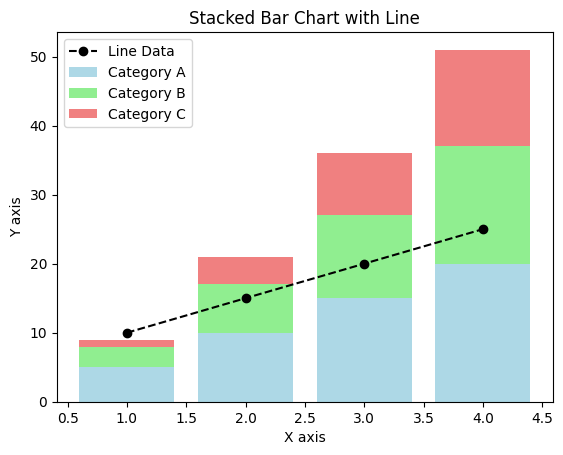

In [8]:
import matplotlib.pyplot as plt

# Example data
x = range(1, 5)  # For example, 4 groups
category_a = [5, 10, 15, 20]
category_b = [3, 7, 12, 17]
category_c = [1, 4, 9, 14]
line_data = [10, 15, 20, 25]

# Plotting the stacked bars
plt.bar(x, category_a, label="Category A", color="lightblue")
plt.bar(x, category_b, bottom=category_a, label="Category B", color="lightgreen")
# To stack category_c, we need to add the values of category_a and category_b for the bottom parameter
combined_bottom = [a + b for a, b in zip(category_a, category_b)]
plt.bar(x, category_c, bottom=combined_bottom, label="Category C", color="lightcoral")

# Adding the line plot
plt.plot(x, line_data, label="Line Data", color="black", marker="o", linestyle="--")

# Adding labels and legend
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.title("Stacked Bar Chart with Line")
plt.legend()

# Show plot
plt.show()

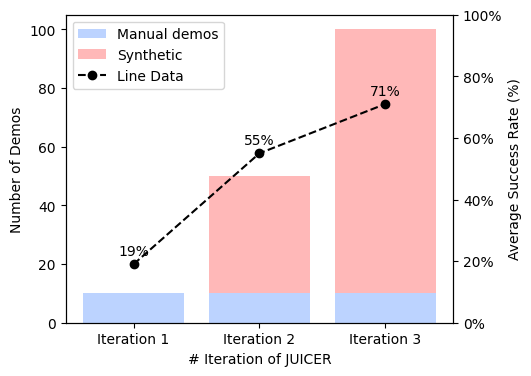

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

x = range(1, 4)
category_a = [10, 10, 10]
category_b = [0, 40, 90]
line_data = [19, 55, 71]

x_labels = ["Iteration 1", "Iteration 2", "Iteration 3"]
# x = range(1, 3)
# category_a = [10, 10]
# category_b = [0, 90]
# line_data = [19, 71]

# x_labels = ["Iteration 1", "Iteration 2"]

# Creating a subplot
fig, ax1 = plt.subplots(figsize=(5, 4))

# Plotting the stacked bars on the first axis
bar1 = ax1.bar(x, category_a, label="Manual demos", color="#BCD3FF")
bar2 = ax1.bar(x, category_b, bottom=category_a, label="Synthetic", color="#FFB8B8")
ax1.set_xlabel("# Iteration of JUICER")
ax1.set_ylabel("Number of Demos")

# Set custom x-axis tick labels
ax1.set_xticks(x)  # Set the positions of the x-ticks
ax1.set_xticklabels(x_labels)  # Set the custom labels for each tick

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
(line,) = ax2.plot(
    x, line_data, label="Line Data", color="black", marker="o", linestyle="--"
)
ax2.set_ylabel("Average Success Rate (%)")
ax2.set_ylim(0, 100)

# Format the right y-axis as percent
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=0))


# Adding labels above each point on the line
for i, txt in enumerate(line_data):
    ax2.text(x[i], line_data[i] + 2, f"{txt}%", ha="center", va="bottom", color="black")


# Creating combined legend
handles, labels = ax1.get_legend_handles_labels()
handles.append(line)  # Adding the line plot handle to the list of handles
labels.append("Line Data")  # Adding the line plot label to the list of labels

# Displaying the combined legend
ax1.legend(handles, labels, loc="upper left")

# fig.suptitle("Stacked Bar Chart with Line")

plt.savefig(fig_base / "bootstrap_success.pdf")

plt.show()

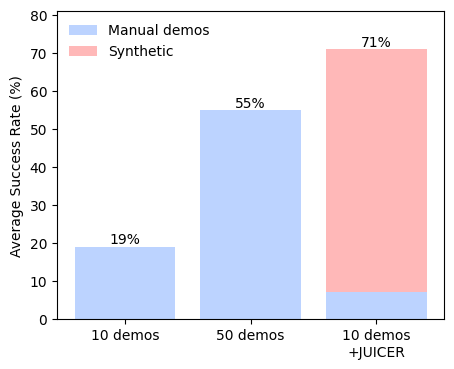

In [3]:
import matplotlib.pyplot as plt

x = range(1, 4)
category_a = [10, 50, 10]
category_b = [0, 0, 90]
line_data = [19, 55, 71]

x_labels = ["10 demos", "50 demos", "10 demos\n+JUICER"]

# Adjusting category_a and category_b to fit the total heights specified by line_data
# Calculate the total of category_a and category_b for each stack
totals = [a + b for a, b in zip(category_a, category_b)]

# Calculate the adjusted heights
adjusted_a = [a / t * l if t else 0 for a, t, l in zip(category_a, totals, line_data)]
adjusted_b = [l - a for a, l in zip(adjusted_a, line_data)]

# Creating a subplot
fig, ax1 = plt.subplots(figsize=(5, 4))

# Plotting the adjusted stacked bars on the first axis
bar1 = ax1.bar(x, adjusted_a, label="Manual demos", color="#BCD3FF")
bar2 = ax1.bar(x, adjusted_b, bottom=adjusted_a, label="Synthetic", color="#FFB8B8")

# ax1.set_xlabel("# Iteration of JUICER")
ax1.set_ylabel("Average Success Rate (%)")

# Set custom x-axis tick labels
ax1.set_xticks(x)  # Set the positions of the x-ticks
ax1.set_xticklabels(x_labels)  # Set the custom labels for each tick

# Adjust y-axis labels to reflect the actual values
ax1.set_ylim(
    0, max(line_data) + 10
)  # Adjust ylim to fit the highest line_data value plus some margin

# Add data labels atop each bar
for xpos, value in zip(x, line_data):
    ax1.text(xpos, value, f"{value}%", ha="center", va="bottom")

# Creating legend
ax1.legend(loc="upper left", frameon=False)


plt.savefig(fig_base / "bootstrap_success.pdf")


plt.show()

# Render new rollouts in high resolution

In [1]:
from src.gym import get_env

from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    create_mp4_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

import numpy as np

base_dir = Path("tmp")

Importing module 'gym_38' (/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.2.1+cu121
Device count 1
/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /data/scratch/ankile/.cache as PyTorch extensions root...
Emitting ninja build file /data/scratch/ankile/.cache/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


In [10]:
for task in tqdm(["one_leg", "round_table", "lamp", "square_table"]):
    if task != "square_table":
        continue
    paths = get_raw_paths(
        environment="sim",
        demo_source="rollout",
        demo_outcome="success",
        task=task,
        randomness="low",
    )

    path = sorted(paths, reverse=True)[0]

    print(f"Rendering {path}")

    imgs = []

    for obs in unpickle_data(path)["observations"]:
        imgs.append(obs["color_image2"])

    imgs = np.array(imgs)
    create_mp4_jupyter(imgs, base_dir / f"rollout_highres_{task}.mp4", fps=20)

  0%|          | 0/4 [00:00<?, ?it/s]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/rollout/low/success/*.pkl*
Rendering /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/rollout/low/success/2024-03-19T07:59:07.pkl
File saved as tmp/rollout_highres_square_table.mp4


100%|██████████| 4/4 [00:17<00:00,  4.41s/it]


# Rerender old rollouts

In [1]:
from src.gym import get_env

from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    create_mp4_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

import numpy as np

from isaacgym import gymtorch, gymapi
import torch


base_dir = Path("tmp")

Importing module 'gym_38' (/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.2.1+cu121
Device count 1
/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /data/scratch/ankile/.cache as PyTorch extensions root...
Emitting ninja build file /data/scratch/ankile/.cache/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


In [2]:
env = get_env(
    gpu_id=0,
    furniture="one_leg",
    num_envs=1,
    randomness="low",
    resize_img=False,
)

In [3]:
paths = get_raw_paths(
    environment="sim",
    demo_source="teleop",
    demo_outcome="success",
    task="one_leg",
    randomness="low",
)

path = sorted(paths, reverse=True)[0]

print(f"Rendering {path}")

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/teleop/low/success/*.pkl*
Rendering /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/teleop/low/success/2024-02-01T10:25:02.pkl


In [4]:
data = unpickle_data(path)

data.keys()

dict_keys(['observations', 'actions', 'rewards', 'skills', 'success', 'furniture', 'error', 'error_description', 'augment_states'])

In [11]:
new_obs = env.reset()
imgs = []

root_positions = env.root_tensor[:, 0:3]
root_orientations = env.root_tensor[:, 3:7]
root_linvels = env.root_tensor[:, 7:10]
root_angvels = env.root_tensor[:, 10:13]

dof_pos = env.dof_pos
dof_vel = env.dof_vel

rb_states = env.rb_states

num_actors = env.root_tensor.shape[0]

for obs in tqdm(data["observations"]):
    imgs.append(new_obs["color_image2"].squeeze().cpu().numpy())

    # Set the root state directly
    offsets = torch.tensor([0, 0.0, 0.1]).repeat(num_actors).reshape(-1, 3).float().cuda()
    root_positions += offsets
    env.isaac_gym.set_actor_root_state_tensor(env.sim, gymtorch.unwrap_tensor(env.root_tensor))

    # Set the DOF state directly
    # dof_pos += 0.1
    # env.isaac_gym.set_dof_state_tensor(env.sim, gymtorch.unwrap_tensor(env.dof_states))

    # Set the rigid body state directly
    # rb_states[:, 0:3] += 0.1
    # env.isaac_gym.set_rigid_body_state_tensor(env.sim, gymtorch.unwrap_tensor(rb_states))


    # Update all the renderers
    env.isaac_gym.fetch_results(env.sim, True)
    env.isaac_gym.step_graphics(env.sim)

    # # Refresh tensors
    env.isaac_gym.refresh_dof_state_tensor(env.sim)
    env.isaac_gym.refresh_dof_force_tensor(env.sim)
    env.isaac_gym.refresh_rigid_body_state_tensor(env.sim)
    env.isaac_gym.refresh_jacobian_tensors(env.sim)
    env.isaac_gym.refresh_mass_matrix_tensors(env.sim)

    env.isaac_gym.render_all_camera_sensors(env.sim)
    env.isaac_gym.start_access_image_tensors(env.sim)

    env.isaac_gym.end_access_image_tensors(env.sim)

    # Get the image
    new_obs = env.get_observation()


INFO: Found collision-free init pose
100%|██████████| 641/641 [00:05<00:00, 118.29it/s]


In [12]:
# Render the video
imgs = np.array(imgs)
create_mp4_jupyter(imgs, base_dir / f"teleop_highres_one_leg_2.mp4", fps=20)

File saved as tmp/teleop_highres_one_leg_2.mp4


In [7]:
env.isaac_gym.get_sim_dof_count(env.sim), env.isaac_gym.get_sim_rigid_body_count(env.sim)

(9, 31)

In [ ]:
# self.isaac_gym.fetch_results(self.sim, True)
# self.isaac_gym.step_graphics(self.sim)

# # Refresh tensors.
# self.isaac_gym.refresh_dof_state_tensor(self.sim)
# self.isaac_gym.refresh_dof_force_tensor(self.sim)
# self.isaac_gym.refresh_rigid_body_state_tensor(self.sim)
# self.isaac_gym.refresh_jacobian_tensors(self.sim)
# self.isaac_gym.refresh_mass_matrix_tensors(self.sim)
# self.isaac_gym.render_all_camera_sensors(self.sim)

# self.isaac_gym.start_access_image_tensors(self.sim)

In [7]:
obs.keys()

dict_keys(['robot_state', 'color_image1', 'color_image2', 'parts_poses'])

In [5]:
def offset_robot_state(observations):
    robot_states = [obs['robot_state'] for obs in observations]
    parts_poses = [obs['parts_poses'] for obs in observations]

    # Remove the first robot_state entry
    robot_states = robot_states[3:]

    # Align the robot_states with parts_poses
    aligned_observations = []
    for i in range(len(robot_states)):
        aligned_obs = {
            'robot_state': robot_states[i],
            'color_image1': observations[i]['color_image1'],
            'color_image2': observations[i]['color_image2'],
            'parts_poses': parts_poses[i]
        }
        aligned_observations.append(aligned_obs)

    return aligned_observations

In [9]:
env.reset()
imgs = []

observations = data["observations"]
observations = offset_robot_state(observations)

for obs in tqdm(data["observations"]):
    # Set the desired state
    env.reset_env_to(env_idx=0, state=obs)

    # torque_action = torch.zeros_like(env.dof_pos)
    # env.isaac_gym.set_dof_actuation_force_tensor(
    #     env.sim, gymtorch.unwrap_tensor(torque_action)
    # )

    # num_dofs = env.isaac_gym.get_sim_dof_count(env.sim)
    # actions = torch.zeros(num_dofs).float().cuda()
    # env.isaac_gym.set_dof_actuation_force_tensor(env.sim, gymtorch.unwrap_tensor(actions))

    env.isaac_gym.simulate(env.sim)

    # env.reset_env_to(env_idx=0, state=obs)

    # Update all the renderers
    env.isaac_gym.fetch_results(env.sim, True)
    env.isaac_gym.step_graphics(env.sim)

    # Refresh tensors
    env.isaac_gym.refresh_dof_state_tensor(env.sim)
    env.isaac_gym.refresh_dof_force_tensor(env.sim)
    env.isaac_gym.refresh_rigid_body_state_tensor(env.sim)
    env.isaac_gym.refresh_jacobian_tensors(env.sim)
    env.isaac_gym.refresh_mass_matrix_tensors(env.sim)

    # env.isaac_gym.refresh_actor_root_state_tensor(env.sim)

    env.isaac_gym.render_all_camera_sensors(env.sim)
    env.isaac_gym.start_access_image_tensors(env.sim)

    env.isaac_gym.end_access_image_tensors(env.sim)

    # Get the image
    obs = env.get_observation()

    imgs.append(obs["color_image2"].squeeze().cpu().numpy())

INFO: Found collision-free init pose
  0%|          | 0/641 [00:00<?, ?it/s]

100%|██████████| 641/641 [00:18<00:00, 33.82it/s]


In [7]:
env.reset()
imgs = []

for obs in tqdm(data["observations"]):
    # env.reset_env_to(env_idx=0, state=obs)

    # Set the desired state for robot joint positions
    dof_pos = torch.from_numpy(np.concatenate(
        [
            obs["robot_state"]["joint_positions"],
            np.array([obs["robot_state"]["gripper_width"] / 2] * 2),
        ],
    )).float().cuda()  # Convert the tensor to float32
    # env.reset_franka_all(dof_pos)
    dof_vel = torch.zeros_like(dof_pos).cuda()  # Set DOF velocities to zero

    # Concatenate dof_pos and dof_vel along the second dimension
    dof_state = torch.stack((dof_pos, dof_vel), dim=1)

    # Get the actor index correctly
    actor_idx = env.franka_actor_idxs_all_t[0].reshape(1, 1).cuda()

    env.isaac_gym.set_dof_state_tensor_indexed(env.sim, gymtorch.unwrap_tensor(dof_state), gymtorch.unwrap_tensor(actor_idx), 1)

    # Set the desired state for parts poses
    parts_poses = torch.from_numpy(obs["parts_poses"]).float().cuda()  # Convert the tensor to float32
    env.isaac_gym.set_actor_root_state_tensor(env.sim, gymtorch.unwrap_tensor(parts_poses))

    # Update all the renderers
    env.isaac_gym.fetch_results(env.sim, True)
    env.isaac_gym.step_graphics(env.sim)

    # Refresh tensors
    env.isaac_gym.refresh_dof_state_tensor(env.sim)
    env.isaac_gym.refresh_dof_force_tensor(env.sim)
    env.isaac_gym.refresh_rigid_body_state_tensor(env.sim)
    env.isaac_gym.refresh_jacobian_tensors(env.sim)
    env.isaac_gym.refresh_mass_matrix_tensors(env.sim)

    env.isaac_gym.render_all_camera_sensors(env.sim)
    env.isaac_gym.start_access_image_tensors(env.sim)

    env.isaac_gym.end_access_image_tensors(env.sim)

    # Get the image
    obs = env.get_observation()

    imgs.append(obs["color_image2"].squeeze().cpu().numpy())

INFO: Found collision-free init pose
  0%|          | 0/641 [00:00<?, ?it/s]

[Error] [carb.gym.plugin] Incompatible shape of root state tensor in function GymSetActorRootStateTensor: expected (12, 13), received (35)
[Error] [carb.gym.plugin] Incompatible shape of root state tensor in function GymSetActorRootStateTensor: expected (12, 13), received (35)
[Error] [carb.gym.plugin] Incompatible shape of root state tensor in function GymSetActorRootStateTensor: expected (12, 13), received (35)
[Error] [carb.gym.plugin] Incompatible shape of root state tensor in function GymSetActorRootStateTensor: expected (12, 13), received (35)
[Error] [carb.gym.plugin] Incompatible shape of root state tensor in function GymSetActorRootStateTensor: expected (12, 13), received (35)
[Error] [carb.gym.plugin] Incompatible shape of root state tensor in function GymSetActorRootStateTensor: expected (12, 13), received (35)
  1%|          | 6/641 [00:00<00:14, 44.71it/s][Error] [carb.gym.plugin] Incompatible shape of root state tensor in function GymSetActorRootStateTensor: expected (12,

# Main results bar chart

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

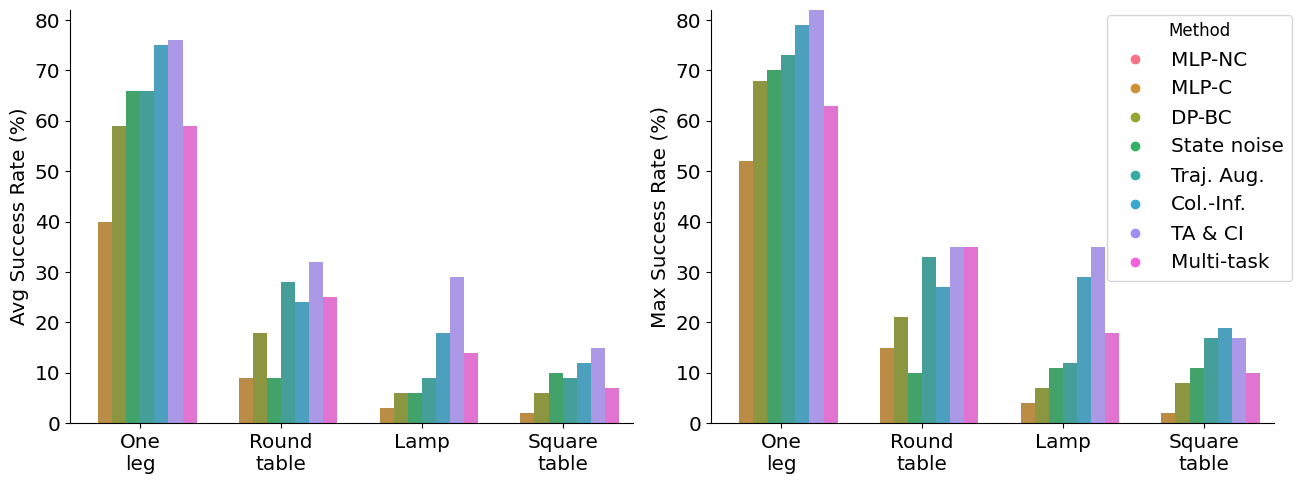

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Increase font size globally and set font to Times New Roman
plt.rcParams.update(
    {
        "font.size": 12,  # Adjust the base font size as needed
        "font.family": "Times New Roman",
        "legend.fontsize": "large",  # Adjust legend font size
        "axes.labelsize": "large",  # Adjust axis labels font size
        "axes.titlesize": "x-large",  # Adjust axis title font size
        "xtick.labelsize": "large",  # Adjust X-axis tick label size
        "ytick.labelsize": "large",  # Adjust Y-axis tick label size
    }
)

# Original data from the LaTeX table
data = {
    "Method": [
        "MLP-NC",
        "MLP-C",
        "DP-BC",
        "State noise",
        "Traj. Aug.",
        "Col.-Inf.",
        "TA & CI",
        "Multi-task",
    ],
    "One leg Avg": [0, 40, 59, 66, 66, 75, 76, 59],
    "One leg Max": [0, 52, 68, 70, 73, 79, 83, 63],
    "Round table Avg": [0, 9, 18, 9, 28, 24, 32, 25],
    "Round table Max": [0, 15, 21, 10, 33, 27, 35, 35],
    "Lamp Avg": [None, 3, 6, 6, 9, 18, 29, 14],
    "Lamp Max": [None, 4, 7, 11, 12, 29, 35, 18],
    "Square table Avg": [None, 2, 6, 10, 9, 12, 15, 7],
    "Square table Max": [None, 2, 8, 11, 17, 19, 17, 10],
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)
df = df.set_index("Method")

# Melt the DataFrame to have a suitable form for seaborn's barplot
df_melted = df.reset_index().melt(
    id_vars="Method", var_name="Task", value_name="Success Rate"
)

# Add 'Type' column to differentiate between Avg and Max
df_melted["Metric"] = df_melted["Task"].str.extract(r"(\bAvg|\bMax)")
df_melted["Task"] = df_melted["Task"].str.replace(r" Avg", "").str.replace(r" Max", "")

# Plot the grouped barplot using catplot
g = sns.catplot(
    x="Task",
    y="Success Rate",
    hue="Method",
    # row="Metric",
    col="Metric",
    sharey=False,
    data=df_melted,
    kind="bar",
    # height=4,
    # aspect=2,
    height=5.0,  # 5.0 good
    aspect=1.3,  # 1.0 good-ish
    palette="husl",
    legend=False,
)

# Set titles and labels
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
# g.fig.suptitle('Success Rates (%) of Methods Across Tasks') # - Average vs Maximum')
# g.set_titles("{col_name} {col_var}")

# Iterate over each subplot in the FacetGrid to set y-axis labels
for ax, metric in zip(g.axes.flat, ["Avg", "Max"]):
    ax.set_ylim([0, 82])
    ax.set_ylabel(f"{metric} Success Rate (%)")
    # ax.set_xlabel(f'Task')
    ax.set_xlabel(f"")
    ax.set_title(f"")

    # Get current labels
    labels = [label.get_text() for label in ax.get_xticklabels()]
    # Replace spaces with newline characters as needed
    new_labels = [label.replace(" ", "\n") for label in labels]
    # Set new labels
    ax.set_xticklabels(
        new_labels
    )  # , rotation=45)  # Optional: adjust rotation for better readability


# Create the legend manually (TODO)
# Manually creating the legend
# Get the unique methods from your DataFrame to create legend entries
methods = df_melted["Method"].unique()

# Use seaborn's color palette for consistency with the plot
palette = sns.color_palette("husl", len(methods))

# Create legend handles
legend_handles = [
    plt.Line2D([0], [0], color=palette[i], marker="o", linestyle="", label=method)
    for i, method in enumerate(methods)
]

# Add the legend to the figure
# g.fig.legend(handles=legend_handles, title='Method', bbox_to_anchor=(0.75, 0.95), loc='upper left')
# g.fig.legend(handles=legend_handles, title='Method', bbox_to_anchor=(0.875, 1.05), loc='upper left')
g.figure.legend(
    handles=legend_handles,
    title="Method",
    bbox_to_anchor=(0.85, 0.975),
    loc="upper left",
)

# Show the plot
plt.tight_layout()

# Since we're adding a legend outside the plot, adjust the subplots to fit the figure area
# g.fig.subplots_adjust(right=0.7)

# plt.show()
plt.savefig("success_rate_barplot.pdf", bbox_inches="tight")